# Adversarial Attack Project (FGSM + PGD)
This notebook contains full runnable code for training a CNN on CIFAR-10
and generating FGSM and PGD adversarial attacks.

In [25]:
# ============================================================
#   ADVERSARIAL ATTACK PROJECT - FULL COLAB NOTEBOOK IN ONE CELL
#   FGSM + PGD Attacks on CIFAR-10 using a CNN
# ============================================================

# !pip install torch torchvision matplotlib pillow 

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)




print("Block Successfully ran!")


Using device: cuda
Block Successfully ran!


# 1. Define Simple CNN

In [26]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 256), nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

print("Block Successfully ran!")

Block Successfully ran!


# 2. FGSM Attack

In [27]:
def fgsm_attack(model, loss_fn, images, labels, epsilon):
    images = images.clone().detach().to(device)
    images.requires_grad = True

    output = model(images)
    loss = loss_fn(output, labels)
    model.zero_grad()
    loss.backward()

    adv = images + epsilon * images.grad.sign()
    return torch.clamp(adv, 0, 1)

print("Block Successfully ran!")

Block Successfully ran!


# 3. PGD Attack


In [28]:
def pgd_attack(model, loss_fn, images, labels, epsilon, alpha, iters):
    ori = images.clone().detach().to(device)
    adv = ori.clone().detach()

    for _ in range(iters):
        adv.requires_grad = True
        output = model(adv)
        loss = loss_fn(output, labels)
        model.zero_grad()
        loss.backward()

        adv = adv + alpha * adv.grad.sign()
        delta = torch.clamp(adv - ori, -epsilon, epsilon)
        adv = torch.clamp(ori + delta, 0, 1).detach()

    return adv

print("Block Successfully ran!")

Block Successfully ran!


# 4. Load CIFAR-10


In [29]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor()
])

transform_test = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True,
                                        transform=transform_train)
testset  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True,
                                        transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader  = DataLoader(testset, batch_size=128, shuffle=False)

# ---------------------------
# 5. Train model (3 epochs)
# ---------------------------

model = SimpleCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

print("Training model...")
for epoch in range(3):
    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = loss_fn(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/3 completed")

print("Block Successfully ran!")


Training model...
Epoch 1/3 completed
Epoch 2/3 completed
Epoch 3/3 completed
Block Successfully ran!


# 6. Attack Evaluation


In [32]:
def evaluate_attack(name, adv_images):
    model.eval()
    clean_correct = adv_correct = 0
    orig_correct = fooled = 0

    j = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        clean_pred = model(images).argmax(1)
        # adv_pred = model(adv_images[j:j+len(images)]).argmax(1)
        adv_batch = adv_images[j:j+len(images)].to(device)
        adv_pred = model(adv_batch).argmax(1)

        clean_correct += (clean_pred == labels).sum().item()
        adv_correct += (adv_pred == labels).sum().item()

        for c,a,l in zip(clean_pred, adv_pred, labels):
            if c == l:                       # originally correct
                orig_correct += 1
                if a != l: fooled += 1       # now wrong → fooled

        j += len(images)

    print(f"\n=== {name} ===")
    print("Clean Accuracy:", clean_correct/len(testset))
    print("Adv Accuracy:  ", adv_correct/len(testset))
    print("ASR:           ", fooled / orig_correct)

print("Block Successfully ran!")

Block Successfully ran!


# 7. Visualization Helpers


In [33]:
def show_images(orig, adv, n=1):
    plt.figure(figsize=(8,2*n))
    for i in range(n):
        plt.subplot(n,2,2*i+1)
        plt.imshow(orig[i].detach().permute(1,2,0).cpu())
        plt.title("Original")
        plt.axis("off")

        plt.subplot(n,2,2*i+2)
        plt.imshow(adv[i].detach().permute(1,2,0).cpu())
        plt.title("Adversarial")
        plt.axis("off")

    plt.show()


def show_perturbation(original, adversarial, scale=20):
    diff = (adversarial - original).abs()
    diff = torch.clamp(diff * scale, 0, 1)
    plt.figure(figsize=(4,4))
    plt.imshow(diff[0].detach().permute(1,2,0).cpu())
    plt.title(f"Perturbation Heatmap (x{scale})")
    plt.axis("off")
    plt.show()


def show_grid(originals, adversarials, n=10):
    originals = originals[:n]
    adversarials = adversarials[:n]

    plt.figure(figsize=(12,2*n))
    for i in range(n):
        plt.subplot(n,2,2*i+1)
        plt.imshow(originals[i].detach().permute(1,2,0).cpu())
        plt.title("Original")
        plt.axis("off")

        plt.subplot(n,2,2*i+2)
        plt.imshow(adversarials[i].detach().permute(1,2,0).cpu())
        plt.title("Adversarial")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

print("Block Successfully ran!")

Block Successfully ran!


# 8. Run Attacks (FGSM & PGD) for multiple epsilons



Running FGSM attack with epsilon=0.03 ...

=== FGSM (eps=0.03) ===
Clean Accuracy: 0.4756
Adv Accuracy:   0.132
ASR:            0.7224558452481077

Running FGSM attack with epsilon=0.1 ...

=== FGSM (eps=0.1) ===
Clean Accuracy: 0.4756
Adv Accuracy:   0.0058
ASR:            0.9878048780487805

Running FGSM attack with epsilon=0.2 ...

=== FGSM (eps=0.2) ===
Clean Accuracy: 0.4756
Adv Accuracy:   0.0004
ASR:            0.9991589571068125

Running PGD attack with epsilon=0.03 ...

=== PGD (eps=0.03) ===
Clean Accuracy: 0.4756
Adv Accuracy:   0.1026
ASR:            0.7842724978973927

Running PGD attack with epsilon=0.1 ...

=== PGD (eps=0.1) ===
Clean Accuracy: 0.4756
Adv Accuracy:   0.0002
ASR:            0.9995794785534062

Running PGD attack with epsilon=0.2 ...

=== PGD (eps=0.2) ===
Clean Accuracy: 0.4756
Adv Accuracy:   0.0
ASR:            1.0

FGSM Example:


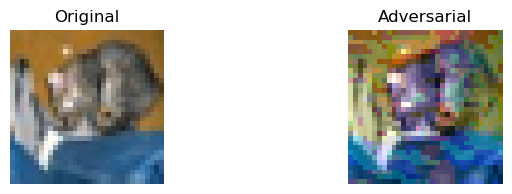

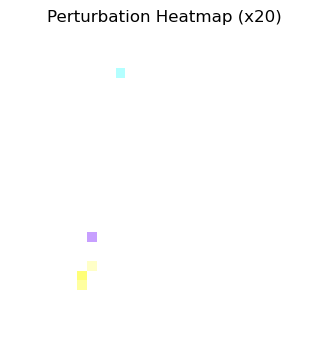


PGD Example:


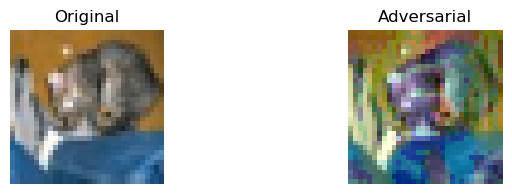

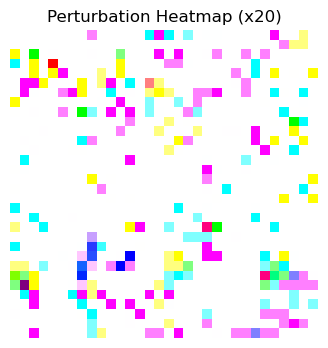


10-sample FGSM image grid:


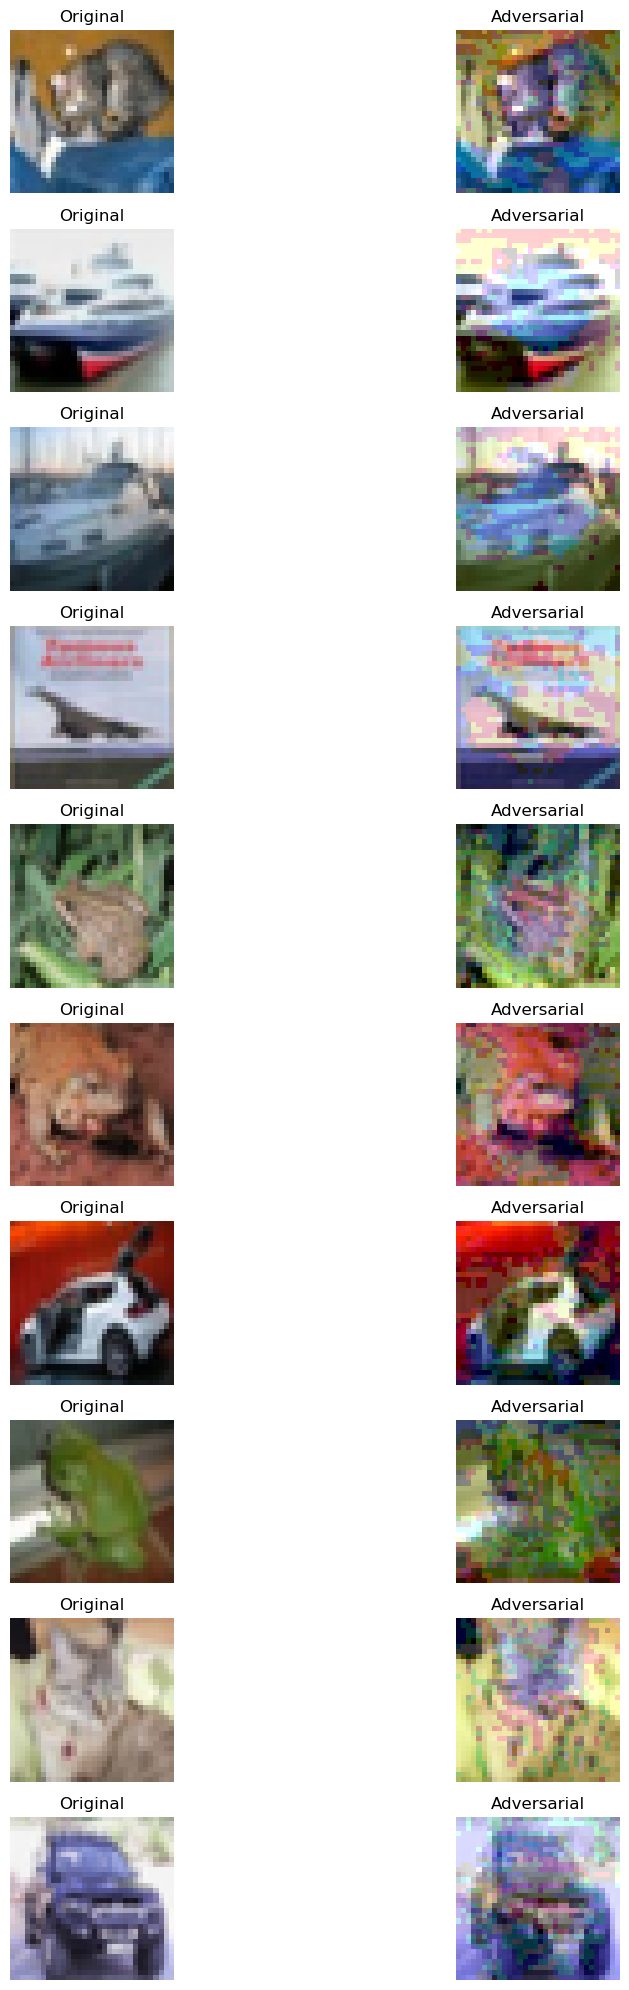

Done!
Block Successfully ran!


In [34]:
epsilons = [0.03, 0.1, 0.2]   # weak, medium, strong attacks

fgsm_results = {}
pgd_results = {}

# ---- FGSM ----
for eps in epsilons:
    print(f"\nRunning FGSM attack with epsilon={eps} ...")
    adv_batches = []

    for images, labels in testloader:
        adv = fgsm_attack(model, loss_fn,
                          images.to(device),
                          labels.to(device),
                          epsilon=eps)
        adv_batches.append(adv.cpu())

    adv_images_fgsm = torch.cat(adv_batches)
    fgsm_results[eps] = adv_images_fgsm
    evaluate_attack(f"FGSM (eps={eps})", adv_images_fgsm)

# ---- PGD ----
for eps in epsilons:
    print(f"\nRunning PGD attack with epsilon={eps} ...")
    adv_batches = []

    for images, labels in testloader:
        adv = pgd_attack(model, loss_fn,
                         images.to(device),
                         labels.to(device),
                         epsilon=eps,
                         alpha=eps/4,
                         iters=20)
        adv_batches.append(adv.cpu())

    adv_images_pgd = torch.cat(adv_batches)
    pgd_results[eps] = adv_images_pgd
    evaluate_attack(f"PGD (eps={eps})", adv_images_pgd)


# ===========================================
# 9. Visualizations
# ===========================================

# Show example for epsilon = 0.1
eps_show = 0.1
idx = 0

orig = testset[idx][0].unsqueeze(0)
adv_fgsm = fgsm_results[eps_show][idx].unsqueeze(0)
adv_pgd  = pgd_results[eps_show][idx].unsqueeze(0)

print("\nFGSM Example:")
show_images(orig, adv_fgsm, n=1)
show_perturbation(orig, adv_fgsm)

print("\nPGD Example:")
show_images(orig, adv_pgd, n=1)
show_perturbation(orig, adv_pgd)

# Grid view for FGSM images
print("\n10-sample FGSM image grid:")
orig_batch = torch.stack([testset[i][0] for i in range(10)])
adv_batch  = fgsm_results[eps_show][:10]
show_grid(orig_batch, adv_batch, n=10)

print("Done!")

print("Block Successfully ran!")